# Investigating clinical notes regarding falls in older adults
Author: Wendy Phillips

## Problem statement

Falls in older adults are frequent and can have major health impacts.

## Data description

Clinical notes and metadata associated with ~115,000 visits to the doctor were analyzed.

## Analytic approach

Natural Language Processing (NLP) was applied to the clinical notes to extract informative content. Specifically, the NLP tool spaCy was used to build a model that could identify and label specific spans of the text that held information of interest. 

In [1]:
import numpy as np
import pandas as pd
import json
from pathlib import Path
import re
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from spacy.tokens import Span
from spacy.tokens import DocBin
import collections

In [2]:
print(spacy.__version__)

3.6.1


## Import data 

#### Load variable mapping

In [3]:
with Path("primary_data/variable_mapping.json").open("r") as f:
    mapping = json.load(f, parse_int=True)

# convert the encoded values in the mapping to integers since they get read in as strings
for c in mapping.keys():
    mapping[c] = {int(k): v for k, v in mapping[c].items()}

#### Load primary data

In [4]:
df = pd.read_csv(
    "primary_data/primary_data.csv",
    # set columns that can be null to nullable ints
    dtype={"body_part_2": "Int64", "diagnosis_2": "Int64"},
)

In [5]:
df.shape

(115128, 22)

In [6]:
df.head(3)

,cpsc_case_number,narrative,treatment_date,age,sex,race,other_race,hispanic,diagnosis,other_diagnosis,...,body_part,body_part_2,disposition,location,fire_involvement,alcohol,drug,product_1,product_2,product_3
0,190103269,94YOM FELL TO THE FLOOR AT THE NURSING HOME ON...,2019-01-01,94,1,0,NaN,0,62,NaN,...,75,<NA>,4,5,0,0,0,1807,0,0
1,190103270,86YOM FELL IN THE SHOWER AT HOME AND SUSTAINED...,2019-01-01,86,1,0,NaN,0,62,NaN,...,75,<NA>,4,1,0,0,0,611,0,0
2,190103273,87YOF WAS GETTING UP FROM THE COUCH AND FELL T...,2019-01-01,87,2,0,NaN,0,53,NaN,...,32,<NA>,4,1,0,0,0,679,1807,0


#### Replace numeric values with corresponding strings

In [7]:
decoded_df = df.copy()

for col in mapping.keys():
    decoded_df[col] = decoded_df[col].map(mapping[col])

# Check on the df
decoded_df.head(1)

,cpsc_case_number,narrative,treatment_date,age,sex,race,other_race,hispanic,diagnosis,other_diagnosis,...,body_part,body_part_2,disposition,location,fire_involvement,alcohol,drug,product_1,product_2,product_3
0,190103269,94YOM FELL TO THE FLOOR AT THE NURSING HOME ON...,2019-01-01,94,MALE,N.S.,NaN,Unk/Not stated,62 - INTERNAL INJURY,NaN,...,75 - HEAD,NaN,4 - TREATED AND ADMITTED/HOSPITALIZED,PUBLIC,NO/?,No/Unk,No/Unk,1807 - FLOORS OR FLOORING MATERIALS,0 - None,0 - None


In [8]:
# ensure mappings were applied correctly by checking that the number of missing values did not change
assert (decoded_df.isnull().sum() == df.isnull().sum()).all()

Because the narrative text will be a main focus of this analysis, it deserves some investigation. First, create a column that holds how many characters are in each narrative text string.

In [9]:
# Add character length column
decoded_df['narrative_characters'] = decoded_df['narrative'].str.len()

In [10]:
# Save to file if one wants to come back at this point
# decoded_df.to_csv("decoded_primary_data_with_char_lens.csv")

<Axes: xlabel='narrative_characters', ylabel='Density'>

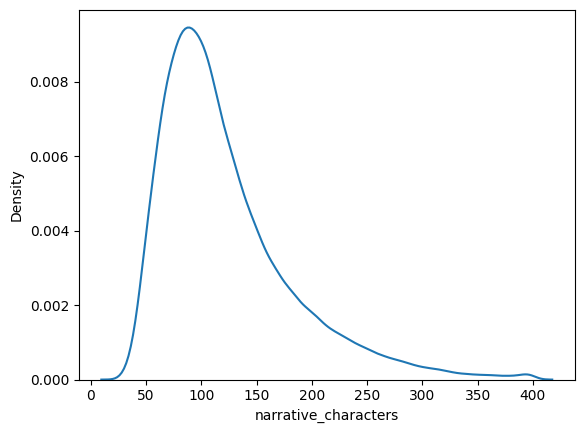

In [11]:
# Exploratory plot of distribution
sns.kdeplot(decoded_df['narrative_characters'])

Find the value that occurs most frequently, called the mode, which is the point at the top of the curve. Also find the 25%, 50% (median) and 75% quantiles of the distribution.

In [12]:
print(decoded_df['narrative_characters'].mode())
print(np.quantile(a=decoded_df['narrative_characters'], q = [0.25,0.5,0.75]))

0    88
Name: narrative_characters, dtype: int64
[ 80. 107. 148.]


I'll add text annotation that gives examples of narrative entries at the different quantiles.

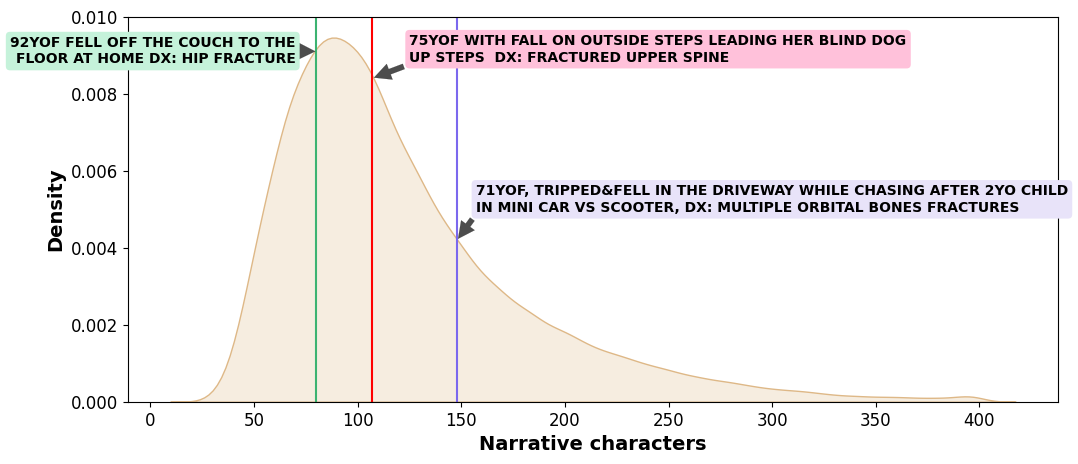

In [13]:
fig, ax = plt.subplots(figsize=(12,5))
sns.kdeplot(decoded_df['narrative_characters'], fill = True, color = 'burlywood')
plt.axvline(x=148, color = 'mediumslateblue')
ax.annotate('71YOF, TRIPPED&FELL IN THE DRIVEWAY WHILE CHASING AFTER 2YO CHILD\nIN MINI CAR VS SCOOTER, DX: MULTIPLE ORBITAL BONES FRACTURES', xy=(148, 0.0042), xytext=(157, 0.005),
            arrowprops=dict(facecolor='#4d4d4d', shrink=0.05, linewidth=0.1), wrap = True, fontsize=10, fontweight = 'bold',
            bbox=dict(boxstyle='round,pad=0.3', edgecolor='none', facecolor='#e8e3f9'))
plt.axvline(x=107, color = 'red')
ax.annotate('75YOF WITH FALL ON OUTSIDE STEPS LEADING HER BLIND DOG\nUP STEPS  DX: FRACTURED UPPER SPINE', xy=(107, 0.0084), xytext=(125, 0.0089),
            arrowprops=dict(facecolor='#4d4d4d', shrink=0.05, linewidth=0.1), wrap = True, fontsize=10,fontweight = 'bold',
            bbox=dict(boxstyle='round,pad=0.3', edgecolor='none', facecolor='#ffc1da'))
plt.axvline(x=80, color = 'mediumseagreen')
ax.annotate('92YOF FELL OFF THE COUCH TO THE\nFLOOR AT HOME DX: HIP FRACTURE', xy=(80, 0.0091), xytext=(70, 0.0095),
            arrowprops=dict(facecolor='#4d4d4d', shrink=0.05, linewidth=0.1), 
            horizontalalignment='right', verticalalignment='top', wrap = True, fontsize=10,fontweight = 'bold',
            bbox=dict(boxstyle='round,pad=0.3', edgecolor='none', facecolor='#c5f2da'))
ax.set_ylim(0, 0.01)
ax.set_xlabel("Narrative characters", fontsize = 14,fontweight = 'bold')
ax.set_ylabel("Density", fontsize = 14,fontweight = 'bold')
ax.tick_params(labelsize=12)
plt.savefig("Character_length_plot.pdf", format="pdf")
plt.show()

## Narrative manipulation
Many abbreviations are used in the clinical text. For those writing the narrative, this saves time and space. Only 400 characters are allowed. However, to make it easier for us to read and for the NLP tools to 'understand', I'll convert some of the commonly used abbreviations into actual words. Additionally, there are frequent cases of lack of spacing between words. I'll fix that, too.  

Most of the dictionary of medical terms as well as the `clean_narrative` function came from another contest participant. I changed and added a few terms and changed and added to some of the function code.

In [14]:
medical_terms = {
    "&": "and",
    "***": "",
    ">>": "clinical diagnosis",
    "@": "at",
    "+": "with",
    "?": "unknown if",
    "abd": "abdomen",
    "af": "accidental fall",
    "afib": "atrial fibrillation",
    "alf": "assisted living facility",
    "aki": "acute kidney injury",
    "am": "morning",
    "ams": "altered mental status",
    "bac": "blood alcohol content",
    "biba": "brought in by ambulance",
    "bwd": "backwards",
    "c/o": "complains of",
    "chi": "closed-head injury",
    "clsd": "closed",
    "cpk": "creatine phosphokinase",
    "cva": "cerebral vascular accident",
    "dn": "down",
    "dtr": "daughter",
    "dx": "clinical diagnosis",
    "ecf": "extended care facility",
    "er": "emergency room",
    "etoh": "ethyl alcohol",
    "eval": "evaluation",
    "fd": "found",
    "ft": "foot",
    "fx": "fracture",
    "fxs": "fractures",
    "fwd": "forwards",
    "glf": "ground level fall",
    "h/o": "history of",
    "hr": "hours",
    "htn": "hypertension",
    "hx": "history of",
    "inj": "injury",
    "inr": "international normalized ratio",
    "intox": "intoxication",
    "lac": "laceration",
    "loc": "loss of consciousness",
    "lt": "left",
    "mech": "mechanical",
    "mult": "multiple",
    "n h ": "nursing home",
    "nh": "nursing home",
    "p/w": "presents with",
    "pm": "afternoon",
    "pt": "patient",
    "pta": "prior to arrival",
    "pts": "patient's",
    "px": "physical examination", # not "procedure",
    "r/o": "rules out",
    "rt": "right",
    "s/p": "after",
    "sah": "subarachnoid hemorrhage",
    "sdh": "acute subdural hematoma",
    "sts": "sit to stand",
    "tr": "trauma",
    "uti": "urinary tract infection",
    "unwit'd": "unwitnessed",
    "w/o": "without",
    "w/": "with",
    "wks": "weeks"
}

def add_space_after(text, target=","):
    replaced_text = re.sub(r'({})(\S)'.format(re.escape(target)), r'{} \2'.format(target),text)
    return replaced_text

def add_space_before(text, target=","):
    replaced_text = re.sub(r'(\S)({})'.format(re.escape(target)), r'\1 {}'.format(target), text)
    return replaced_text

# cleanning
def clean_narrative(text):
    # lowercase everything
    if pd.isna(text):
        return "NA"
    else:     
        text = text.lower()
        
        # unglue DX
        regex_dx = r"([ˆ\W]*(dx)[ˆ\W]*)"
        text = re.sub(regex_dx, r". dx: ", text)
    
        # remove age and sex identifications
        ## regex to capture age and sex (not perfect but captures almost all of the cases)
        regex_age_sex = r"(\d+)\s*?(yof|yf|yo\s*female|yo\s*f|yom|ym|yo\s*male|yo\s*m)"
        age_sex_match = re.search(regex_age_sex, text)
    
        ## format age and sex
        if age_sex_match:
            age = age_sex_match.group(1)
            sex = age_sex_match.group(2)
            
            # probably not best practice but it works with this data
            if "f" in sex:
                #text = text.replace(age_sex_match.group(0), f"{age} years old female")
                text = text.replace(age_sex_match.group(0), f"patient")
            elif "m" in sex:
                #text = text.replace(age_sex_match.group(0), f"{age} years old male")
                text = text.replace(age_sex_match.group(0), f"patient")
                
        text = add_space_after(text, target=",") 
        text = add_space_after(text, target=";") 
        text = add_space_after(text, target=":") 
        text = add_space_before(text, target="--")  
        text = add_space_after(text, target="--")
        text = re.sub("-", " ", text)
        text = re.sub(r"([0-9]+(\.[0-9]+)?)",r" \1 ", text).strip()
        text = re.sub("\.", " ", text)
        
        # The below two are separated from the dictionary because of the '&' character conflict
        #   with the translate medical terms section use of '&'
        text = re.sub("t'd&f", "tripped and fell", text)
        text = re.sub("s'd&f", "slipped and fell",text)     
    
        
        # translate medical terms
        for term, replacement in medical_terms.items():
            if term == "@" or term == ">>" or term == "&" or term == "***" or term == "+" or term == "?":
                pattern = fr"({re.escape(term)})"
                text = re.sub(pattern, f" {replacement} ", text) # force spaces around replacement
                
            else:
                pattern = fr"(?<!-)\b({re.escape(term)})\b(?!-)"
                text = re.sub(pattern, replacement, text)
                            
        # This done after translate medical terms because some use a '/'
        text = add_space_before(text, target="/")  
        text = add_space_after(text, target="/")
        
        # remove extra white spaces
        text = re.sub(r'\s+', ' ', text)
    
        return text.upper()

Check how well that function works to change some complex example narrative text.

In [15]:
text = '72 YOF SLIPPED&FELL OFF 4FT LADDER ONTO THE FLOOR THIS AM DTR FD DN+LOC>>L-3, L-4 FRACTURE, RT RIB FRACTURES X 3'
print("Original text:", text)
print("Clean text:", clean_narrative(text))

Original text: 72 YOF SLIPPED&FELL OFF 4FT LADDER ONTO THE FLOOR THIS AM DTR FD DN+LOC>>L-3, L-4 FRACTURE, RT RIB FRACTURES X 3
Clean text: PATIENT SLIPPED AND FELL OFF 4 FOOT LADDER ONTO THE FLOOR THIS MORNING DAUGHTER FOUND DOWN WITH LOSS OF CONSCIOUSNESS CLINICAL DIAGNOSIS L 3 , L 4 FRACTURE, RIGHT RIB FRACTURES X 3


While it would probably be better for things like "L3" to remain together, I will sacrifice that for the easy advantage of separaing other number-character strings that would be better off separated.  

Proceed with processing all narratives in the data.

In [16]:
# Subset the data to just case id and narrative strings
df_narratives = df.iloc[:, 0:2]

# Apply the text cleaning function to all narrative entries
df_narratives['narrative'] = df_narratives['narrative'].apply(lambda x: clean_narrative(x))

In [17]:
# Rename original narrative column in the decoded df
df_nn = decoded_df.rename(columns={"narrative": "narrative_original"})

# Merge the modified narratives with the decoded dataframe
df_final = pd.merge(df_narratives, df_nn, on="cpsc_case_number", how="left")

# Check head to verify
df_final.head(2)

,cpsc_case_number,narrative,narrative_original,treatment_date,age,sex,race,other_race,hispanic,diagnosis,...,body_part_2,disposition,location,fire_involvement,alcohol,drug,product_1,product_2,product_3,narrative_characters
0,190103269,PATIENT FELL TO THE FLOOR AT THE NURSING HOME ...,94YOM FELL TO THE FLOOR AT THE NURSING HOME ON...,2019-01-01,94,MALE,N.S.,NaN,Unk/Not stated,62 - INTERNAL INJURY,...,NaN,4 - TREATED AND ADMITTED/HOSPITALIZED,PUBLIC,NO/?,No/Unk,No/Unk,1807 - FLOORS OR FLOORING MATERIALS,0 - None,0 - None,91
1,190103270,PATIENT FELL IN THE SHOWER AT HOME AND SUSTAIN...,86YOM FELL IN THE SHOWER AT HOME AND SUSTAINED...,2019-01-01,86,MALE,N.S.,NaN,Unk/Not stated,62 - INTERNAL INJURY,...,NaN,4 - TREATED AND ADMITTED/HOSPITALIZED,HOME,NO/?,No/Unk,No/Unk,611 - BATHTUBS OR SHOWERS,0 - None,0 - None,67


In [18]:
# Save to file if one wants to come back at this point
# df_final.to_csv("corrected_narrative_primary.csv", index=False)

## Model training

To built a labeled training set myself. First, I manually labeled ~400 narrative cases. With that I trained an initial model. Following that, I iteratively applied the model to predict labeled spans, manually corrected the predictions, and then used the compiled labeled set to train a new model. At the same time, I modified my choice of span categories to label, sometimes adding sometimes removing categories. Honestly, it was not a very straight line approach, but I learned as I went along what categories were 'working' and contained information that would be useful in a final analysis.

I took a random sample for the purposes of building and testing labels

In [35]:
random_sample = df_final.sample(n=5000, replace=False, random_state=42)

# Subset to just first two columns containing case # and narrative
random_sample_sub = random_sample.iloc[:,0:2]

# Check the result
random_sample_sub.head(2)

,cpsc_case_number,narrative
80147,220302739,PATIENT WAS SITTING IN A WHEELCHAIR LEANING FO...
48158,210101788,PATIENT WAS PLAYING WITH HER GRANDCHILD WHEN S...


In [19]:
labeled_sets = pd.read_csv('secondary_data/labeled_training_data.csv')
labeled_sets.head(2)

,cpsc_case_number,narrative,span,label
0,190105483,PATIENT HAD A FALL OVER CHRISTMAS LIGHTS AT HO...,HIT HEAD ON THE GROUND,SF
1,190107641,PATIENT WAS TRANSFERRING FROM HER WHEELCHAIR T...,NaN,NaN


Check how long the imported data frame is

In [20]:
len(labeled_sets)

1843

Check how many unique cases are contained in the data set

In [21]:
key_list = labeled_sets.cpsc_case_number.unique()
len(key_list)

1635

Check how many cases in the training set have no labeled span. (Note, this is also an important component of one's training set!)

In [22]:
labeled_sets['span'].isna().sum()

423

Randomly shuffle the key list in case there is some bias in the order of the entries

In [23]:
np.random.seed(99)
np.random.shuffle(key_list, )
key_list

array([230214236, 210861609, 191053268, ..., 220222000, 211022522,
       201005344])

The following chunk of code goes through the labeled training set, processing it to be a list of Spacy doc objects.

In [25]:
nlp = spacy.blank("en")

# keeping span token lengths to appropriately set config
token_lengths = []

# Keeping labels in case I want to check
label_list = []

# This will hold the processed string and span docs
docs=[] 

for case in key_list:
    
    # Subest to just one case
    temp_df = labeled_sets[labeled_sets.cpsc_case_number == case]
    
    # Get the narrative and process into a doc
    nar = temp_df.iloc[0,1]
    doc = nlp(nar)
    
    if len(temp_df)==1:    
        if pd.isna(temp_df.iloc[0,2]):
            print("this entry has no label")
            doc.spans["sc"] = []
            docs.append(doc)
        else:     
            span_text = temp_df.iloc[0,2]
            temp_label = temp_df.iloc[0,3]   
            span_start_char = nar.find(span_text)
            span_end_char = span_start_char + len(span_text)
            
            # Finding the start and end tokens using character offsets
            start_token = None
            end_token = None
            for token in doc:
                if token.idx == span_start_char:
                     start_token = token.i
                if token.idx + len(token.text) == span_end_char:
                    end_token = token.i
                    break
                    
            if start_token is not None and end_token is not None:
                temp_start = start_token
                temp_end = end_token + 1
                
                doc.spans["sc"] = [Span(doc, temp_start, temp_end, temp_label)]
                
                token_lengths.append(temp_end - temp_start)
                label_list.append(temp_label)
            
                docs.append(doc)
            else:
                print(nar, "span=", span_text,"couldn't find tokens")
    else:
        print("temp_df has length > 1")
        span_list = []
        for ent in range(len(temp_df)):
            span_text = temp_df.iloc[ent,2]
            temp_label = temp_df.iloc[ent,3]
            span_start_char = nar.find(span_text)
            span_end_char = span_start_char + len(span_text)
            # print(span_start_char, span_end_char)

            # Finding the start and end tokens using character offsets
            start_token = None
            end_token = None
            for token in doc:
                if token.idx == span_start_char:
                     start_token = token.i
                if token.idx + len(token.text) == span_end_char:
                    end_token = token.i
                    break
            if start_token is not None and end_token is not None:
                temp_start = start_token
                temp_end = end_token + 1             
                span_list.append(Span(doc, temp_start, temp_end, temp_label))
                token_lengths.append(temp_end - temp_start)
                label_list.append(temp_label)
            else:
                print(nar, "span=",span_text, "couldn't find tokens")
        
            doc.spans["sc"] = span_list
        docs.append(doc)

this entry has no label
this entry has no label
temp_df has length > 1
temp_df has length > 1
temp_df has length > 1
temp_df has length > 1
temp_df has length > 1
temp_df has length > 1
temp_df has length > 1
this entry has no label
this entry has no label
this entry has no label
this entry has no label
this entry has no label
this entry has no label
this entry has no label
this entry has no label
this entry has no label
temp_df has length > 1
temp_df has length > 1
this entry has no label
temp_df has length > 1
this entry has no label
this entry has no label
temp_df has length > 1
this entry has no label
this entry has no label
this entry has no label
this entry has no label
this entry has no label
this entry has no label
this entry has no label
this entry has no label
this entry has no label
this entry has no label
this entry has no label
this entry has no label
temp_df has length > 1
this entry has no label
temp_df has length > 1
this entry has no label
temp_df has length > 1
this e

In [26]:
len(docs)

1635

In [27]:
for doc in docs[0:1]:
    print(doc, doc.spans)

PATIENT PRESENTS AFTER A SYNCOPAL EPISODE WITH FALL REPORTS HE WAS GOING UP THE ESCALATOR AT A TEA SHOP AND STARTED TO FEEL DIZZY AND FELL DOWN THE ESCALATOR CLINICAL DIAGNOSIS: SYNCOPE, SKIN TEAR TO HAND, SKING TEAR TO HIP {'sc': [FELL DOWN THE ESCALATOR]}


In [28]:
len(token_lengths)

1420

Check on length of tokens in spans to set appropriate parameters in training config file

In [29]:
print(np.min(token_lengths), np.max(token_lengths), np.median(token_lengths))

2 15 4.0


In [30]:
np.quantile(token_lengths, q =[0.05,0.95])

array([2., 7.])

Want to split the data into train and test such that a single case is not split between the two. Check two consecutive rows to make sure they are separate cases.

In [31]:
docs[1100]

PATIENT WAS IN HER KITCHEN WHEN SHE FELL TO THE KITCHEN FLOOR ONTO BUTTOCKS CLINICAL DIAGNOSIS: ABRASION TO BUTTOCKS

In [32]:
docs[1101]

PATIENT FELL WALKING UP STAIRS; FOOT GOT CAUGHT COMPLAINS OF ABRASIONS TO FACE, KNEES, FOREHEAD CLINICAL DIAGNOSIS: NASAL BONE FRACTURE %

Make training and test sets with the docs, saving in spacy format.

In [33]:
doc_bin = DocBin(docs=docs[0:1101])
doc_bin.to_disk("./train_231003_1635.spacy")

doc_bin = DocBin(docs=docs[1101:])
doc_bin.to_disk("./dev_231003_1635.spacy")

Initialize the training config file. This will get some manual adjustments.

In [34]:
!python -m spacy init config configs/config_spancat_singlelabel.cfg --lang en --pipeline spancat_singlelabel --force 

ℹ Generated config template specific for your use case
- Language: en
- Pipeline: spancat_singlelabel
- Optimize for: efficiency
- Hardware: CPU
- Transformer: None
✔ Auto-filled config with all values
✔ Saved config
configs/config_spancat_singlelabel.cfg
You can now add your data and train your pipeline:
python -m spacy train config_spancat_singlelabel.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


These adjustments, indicated by <---, were made to the above config file:

[components.spancat_singlelabel]
factory = "spancat_singlelabel"  
allow_overlap = false  <---  
negative_weight = 1.0  
scorer = {"@scorers":"spacy.spancat_scorer.v1"}  
spans_key = "sc"  

[components.spancat_singlelabel.suggester]   
@misc = "spacy.ngram_range_suggester.v1"  <---  
min_size = 2 <---  
max_size = 12 <---  

[training]
dev_corpus = "corpora.dev"  
train_corpus = "corpora.train"  
seed = ${system.seed}    
gpu_allocator = ${system.gpu_allocator}   
dropout = 0.1  
accumulate_gradient = 1  
patience = 1600  
max_epochs = 20  <---  
max_steps = 20000  
eval_frequency = 100  <---  
frozen_components = []  
annotating_components = []  
before_to_disk = null  
before_update = null  

[training.score_weights]  
spans_sc_f = 0.3 <---  
spans_sc_p = 0.5 <---  
spans_sc_r = 0.2 <---  

Run the training!

In [34]:
!python -m spacy train configs/config_spancat_singlelabel.cfg --paths.train train_231003_1635.spacy --paths.dev dev_231003_1635.spacy --system.seed 99 --output spacy_falling_model/

ℹ Saving to output directory: spacy_falling_model
ℹ Using CPU
ℹ To switch to GPU 0, use the option: --gpu-id 0

=========================== Initializing pipeline ===========================
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['tok2vec', 'spancat_singlelabel']
ℹ Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS SPANC...  SPANS_SC_F  SPANS_SC_P  SPANS_SC_R  SCORE 
---  ------  ------------  -------------  ----------  ----------  ----------  ------
  0       0          0.00         585.43        0.00        0.00        0.00    0.00
  0     100         23.77        4503.18       14.29       22.17       10.54    0.17
  0     200         29.99         480.10       43.79       44.37       43.23    0.44
  1     300         39.21         345.68       59.16       64.23       54.84    0.61
  1     400         48.51         293.65       75.20       78.64       72.04    0.76
  2     500         48.07         234.

These are the performance values from the 'best' model from that training run.  

- F1:  0.843  
- Precision:  0.902  
- Recall:  0.791  
    
I'm pretty happy with the 90% precision value!     

## Using model 

Load the model and check its component steps,

In [36]:
nlp_spancat = spacy.load("spacy_falling_model/model-best")
nlp_spancat.pipeline

[('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec at 0x2a0325b20>),
 ('spancat_singlelabel',
  <spacy.pipeline.spancat.SpanCategorizer at 0x2a03254c0>)]

**Test model on a subset of the samples**

In [37]:
cols = ['cpsc_case_number','text', 'span_text',  'span_label', ]
output_df = pd.DataFrame(columns=cols)

for row in random_sample_sub.iloc[1000:1050:,0:2].iterrows():
    cpsc = (row[1]['cpsc_case_number'])
    text = (row[1]['narrative'])
    doc = nlp_spancat(text)

    if len(doc.spans["sc"]) == 0:
        df2 = pd.DataFrame([[cpsc,text, "NA", "NA"]], columns= cols)
        output_df = pd.concat([output_df, df2])
    else:
        for span in doc.spans["sc"]:     
            df2 = pd.DataFrame([[cpsc,text, span.text, span.label_,]], columns=cols)
            output_df = pd.concat([output_df, df2])

In [38]:
output_df.head()

,cpsc_case_number,text,span_text,span_label
0,190325590,HEAD INJURY / 91 YOWF WAS AMBULATING IN CHURCH...,FELL DOWN 1 STEP,STR
0,220574884,"PATIENT HAD A SYNCOPAL EVENT IN THE SHOWER, FE...",HITTING HEAD,SU
0,190455101,PATIENT ROLLED OUT OF BED AND FELL ONTO CARPET...,NA,NA
0,210658295,PATIENT FELL IN FLOOR AT HOME CLINICAL DIAGNOS...,NA,NA
0,220303943,PATIENT PATIENT TRIPPED ON DOG WHEN HE WAS HE ...,TRIPPED ON DOG,OBJ


## Run model on all samples

Before running on all samples, double check everything is in working order.

In [39]:
decoded_df.iloc[0:3:,0:2]

,cpsc_case_number,narrative
0,190103269,94YOM FELL TO THE FLOOR AT THE NURSING HOME ON...
1,190103270,86YOM FELL IN THE SHOWER AT HOME AND SUSTAINED...
2,190103273,87YOF WAS GETTING UP FROM THE COUCH AND FELL T...


In [40]:
for row in decoded_df.iloc[0:12:,0:2].iterrows():
    cpsc = (row[1]['cpsc_case_number'])
    text = (row[1]['narrative'])
    doc = nlp_spancat(text)
    print(doc.spans["sc"])

[]
[]
[]
[]
[]
[]
[INTO A PLANTER BOX]
[STRUCK HEAD ON A WOODEN FLOOR]
[LANDED ONTO FACE]
[]
[GOING DOWN A FLIGHT OF STAIRS]
[STRUCK HEAD ON THE FLOOR]


In [41]:
# Create an empty dataframe with column names
cols = ['cpsc_case_number','text', 'span_text', 'span_label']
output_df = pd.DataFrame(columns=cols)

for row in decoded_df.iloc[:,0:2].iterrows():
    cpsc = (row[1]['cpsc_case_number'])
    text = (row[1]['narrative'])
    doc = nlp_spancat(text)

    if len(doc.spans["sc"]) == 0:
        df2 = pd.DataFrame([[cpsc, text, "NA", "NA"]], columns=cols)
        output_df = pd.concat([output_df, df2])
    else:
        for span in doc.spans["sc"]:
            df2 = pd.DataFrame([[cpsc, text, span.text, span.label_]], columns=cols)
            output_df = pd.concat([output_df, df2])

In [42]:
# Quick check of how the output looks
output_df.head(2)

,cpsc_case_number,text,span_text,span_label
0,190103269,94YOM FELL TO THE FLOOR AT THE NURSING HOME ON...,NA,NA
0,190103270,86YOM FELL IN THE SHOWER AT HOME AND SUSTAINED...,NA,NA


In [43]:
len(output_df)

123907

In [44]:
# Save to file for coming back and starting up at this point
# output_df.to_csv("predictions_falling_full_set.csv")

In [45]:
# Read in output if it was saved and want to start here
# temp_df = pd.read_csv("predictions_falling_full_set.csv")
# output_df = temp_df.iloc[:,1:5]
output_df.head(8)

,cpsc_case_number,text,span_text,span_label
0,190103269,94YOM FELL TO THE FLOOR AT THE NURSING HOME ON...,NA,NA
0,190103270,86YOM FELL IN THE SHOWER AT HOME AND SUSTAINED...,NA,NA
0,190103273,87YOF WAS GETTING UP FROM THE COUCH AND FELL T...,NA,NA
0,190103291,67YOF WAS AT A FRIENDS HOUSE AND SLIPPED ON WA...,NA,NA
0,190103294,70YOF WAS STANDING ON A STEP STOOL AND FELL OF...,NA,NA
0,190103298,79YOM WAS STANDING ON A FOLDING LAWN CHAIR AND...,NA,NA
0,190103309,74YOM FELL INTO A PLANTER BOX AND SUSTAINED A ...,INTO A PLANTER BOX,SO
0,190103337,76YOF HAD A SLIP AND FALL AT HOME STRUCK HEAD ...,STRUCK HEAD ON A WOODEN FLOOR,SF


### Process predicted spans into dataframes  

Pivot the DataFrame so that each span label is a column and the span texts are the entries in those columns. A single narrative could have two occurrences of the same span label associated with it. Therefore, when collapsing each case into a single row, make a tuple with the individual span text entries.

In [46]:
def tuple_aggregator(series):
    return tuple(series)

# Pivot the DataFrame
pivot_output_df = output_df.pivot_table(index=['cpsc_case_number', 'text'], columns='span_label', values='span_text', aggfunc=tuple_aggregator).reset_index()
pivot_output_df.columns.name = None 
pivot_output_df.head(3)

,cpsc_case_number,text,NA,OBJ,SF,SO,STR,SU,WT
0,190103269,94YOM FELL TO THE FLOOR AT THE NURSING HOME ON...,"(NA,)",NaN,NaN,NaN,NaN,NaN,NaN
1,190103270,86YOM FELL IN THE SHOWER AT HOME AND SUSTAINED...,"(NA,)",NaN,NaN,NaN,NaN,NaN,NaN
2,190103273,87YOF WAS GETTING UP FROM THE COUCH AND FELL T...,"(NA,)",NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
# Copy the first two columns to new dataframe
binary_df = pivot_output_df.iloc[:,0:2]

# For each span category, convert to binary with 1 if a span was found for that case
#  and add to the binary dataframe
label_cats = ['SO','SF','SU','OBJ','STR','WT']
for lab in label_cats:
    binary_df[lab] = pivot_output_df[lab].map(lambda x: 0 if x == 'NA' or pd.isna(x) else 1)

binary_df.head()

,cpsc_case_number,text,SO,SF,SU,OBJ,STR,WT
0,190103269,94YOM FELL TO THE FLOOR AT THE NURSING HOME ON...,0,0,0,0,0,0
1,190103270,86YOM FELL IN THE SHOWER AT HOME AND SUSTAINED...,0,0,0,0,0,0
2,190103273,87YOF WAS GETTING UP FROM THE COUCH AND FELL T...,0,0,0,0,0,0
3,190103291,67YOF WAS AT A FRIENDS HOUSE AND SLIPPED ON WA...,0,0,0,0,0,0
4,190103294,70YOF WAS STANDING ON A STEP STOOL AND FELL OF...,0,0,0,0,0,0


Merge that binary span presence dataframe with the full dataframe of case information.

In [48]:
combo_df = pd.merge(binary_df, decoded_df, how="left", on="cpsc_case_number")
combo_df.columns

Index(['cpsc_case_number', 'text', 'SO', 'SF', 'SU', 'OBJ', 'STR', 'WT',
       'narrative', 'treatment_date', 'age', 'sex', 'race', 'other_race',
       'hispanic', 'diagnosis', 'other_diagnosis', 'diagnosis_2',
       'other_diagnosis_2', 'body_part', 'body_part_2', 'disposition',
       'location', 'fire_involvement', 'alcohol', 'drug', 'product_1',
       'product_2', 'product_3', 'narrative_characters'],
      dtype='object')

## RESULTS

### Words within labeled spans

While I just made the binary dataframe, I will use it further down. I will start the analysis of the results with the original long format dataframe of four columns: cpsc_case_number, text, span_text, and span_label. 

In [49]:
OBJ_entries = output_df[output_df['span_label'] == 'OBJ']
OBJ_entries.head(2)

,cpsc_case_number,text,span_text,span_label
0,190105485,87YOF TRIPPED OVER A DOG AND FELL TO THE FLOOR...,TRIPPED OVER A DOG,OBJ
0,190107102,72YOF WALKING AT HOME ON CLUTTERED CARPET FLOO...,TRIPPED ON OBJECT,OBJ


In [50]:
len(OBJ_entries)

9665

In [51]:
# I developed this remove list by looking at the most frequent word list
#  and removing those that weren't objects
list_remove_OBJ = ['TRIPPED', 'OVER', 'A', 'AN','ON', 'THE', 'HER', 
                   'OF', 'HIS', 'TRIPPING', 'FALL', 'FELL', 'SLIPPED', 
                   'OWN', 'FEET', 'SOME', 'UP']
OBJ_words = []
for i in range(len(OBJ_entries)):
    temp_entry = OBJ_entries.iloc[i,2]
    temp_text  = temp_entry.split(' ')
    out_temp = list(set(temp_text)-set(list_remove_OBJ))
    out_temp = ['SHOE' if word == 'SHOES' else word for word in out_temp]
    OBJ_words.append(out_temp) 
OBJ_words[0:3]    

[['DOG'], ['OBJECT'], ['RUG']]

In [52]:
def flatten_list(nested_list):
    return [item for sublist in nested_list for item in sublist]

In [53]:
OBJ_word_counts = collections.Counter(flatten_list(OBJ_words))
my_dict = dict(OBJ_word_counts)

rows = []
for key, value in my_dict.items():
    row = {'element': key, 'count': value}
    rows.append(row)
rows[0:5]    

[{'element': 'DOG', 'count': 419},
 {'element': 'OBJECT', 'count': 31},
 {'element': 'RUG', 'count': 1522},
 {'element': 'STEP', 'count': 339},
 {'element': 'SHOE', 'count': 535}]

In [54]:
df = pd.DataFrame(rows).sort_values('count', ascending=False)

df.set_index('element', inplace=True)
OBJ_plot_subset = df.head(14).sort_values('count')

In [55]:
OBJ_plot_subset

,count
element,
OXYGEN,119
SOMETHING,121
CAT,134
WALKER,183
BOX,204
DOOR,218
HOSE,255
CHAIR,270
STEP,339


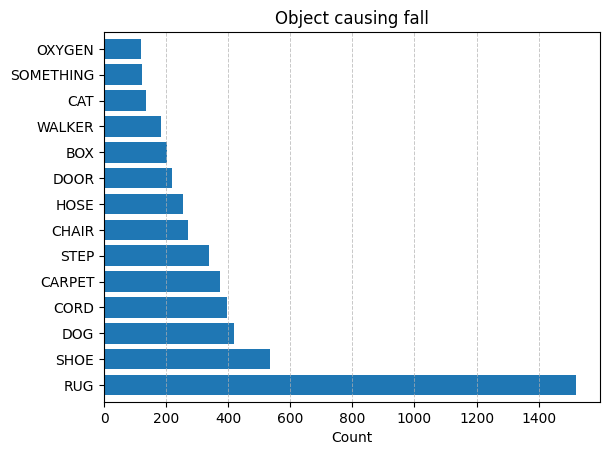

In [56]:
ax = OBJ_plot_subset.plot.barh(width = 0.8)
plt.ylabel('')
plt.xlabel('Count')
plt.title('Object causing fall')
plt.gca().get_legend().remove()
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', linewidth=0.7, alpha=0.7)
plt.savefig("Object_causing.pdf", format="pdf", pad_inches = 0.5, bbox_inches = 'tight')

In [57]:
# Retrieve entries where an object was struck
SO_entries = output_df[output_df['span_label'] == 'SO']
len(SO_entries)

18447

In [58]:
SO_entries.head()

,cpsc_case_number,text,span_text,span_label
0,190103309,74YOM FELL INTO A PLANTER BOX AND SUSTAINED A ...,INTO A PLANTER BOX,SO
0,190104639,75 YOF C/O ANKLE FRACTURE S/P WAS WEARING A SI...,AGAINST THE DOOR,SO
0,190104659,69 YOM C/O FACIAL LACERATION S/P HAVING A NIG...,HITTING HIS FACE ON HIS NIGHTSTAND,SO
0,190106324,85YM SUFFERED FROM SYNCOPAL FALL HITTING HEAD ...,HITTING HEAD ONTO THE WALL,SO
0,190106373,83YF FELL OFF HER STAIR CHAIRS COMING DOWN STA...,HITTING CHEST ONTO A TABLE,SO


In [59]:
list_remove = ['A', 'HEAD', 'HIT', 'THE', 'ON', 'HITTING', 'STRIKING', 
               'HER', 'OF', 'AGAINST', 'STRUCK', 'ONTO', 'HIS', 'INTO',
              'FACE','BACK', 'SIDE', 'CHEST', 'RIGHT', 'LEFT', 'EDGE', 
               'FOREHEAD', 'STAND','FRAME', 'AND', 'COFFEE', 'LANDED', 'ARM'
              ]
SO_words = []
for i in range(len(SO_entries)):
    temp_entry = SO_entries.iloc[i,2]
    temp_text  = temp_entry.split(' ')
    out_temp = list(set(temp_text)-set(list_remove))
    out_temp = ['BATHTUB' if word == 'TUB' else word for word in out_temp]
    SO_words.append(out_temp)    

In [60]:
sns.set_theme(style="white")
              
SO_word_counts = collections.Counter(flatten_list(SO_words))
my_dict = dict(SO_word_counts)

rows = []
for key, value in my_dict.items():
    row = {'element': key, 'count': value}
    rows.append(row)
df = pd.DataFrame(rows).sort_values('count', ascending=False)

df.set_index('element', inplace=True)
SO_plot_subset = df.head(14).sort_values('count')
SO_plot_subset

,count
element,
SINK,327
FURNITURE,338
BED,355
TOILET,461
NIGHTSTAND,492
COUNTER,525
CHAIR,600
CABINET,628
CORNER,659


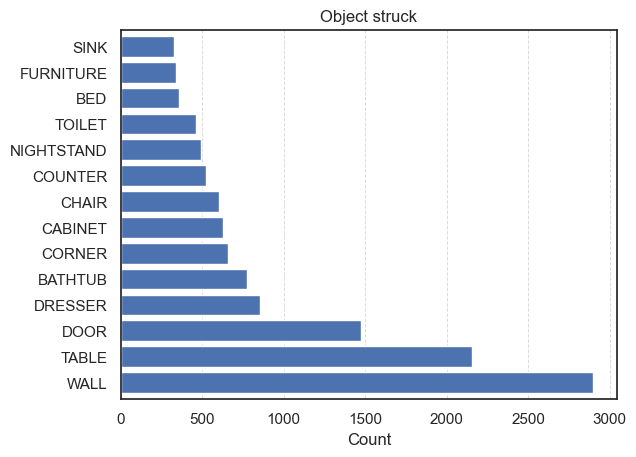

In [61]:
ax = SO_plot_subset.plot.barh(width = 0.8)
plt.ylabel('')
plt.xlabel('Count')
plt.title('Object struck')
plt.gca().get_legend().remove()
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', linewidth=0.7, alpha=0.7)
plt.savefig("Object_struck.pdf", format="pdf", pad_inches = 0.5, bbox_inches = 'tight')

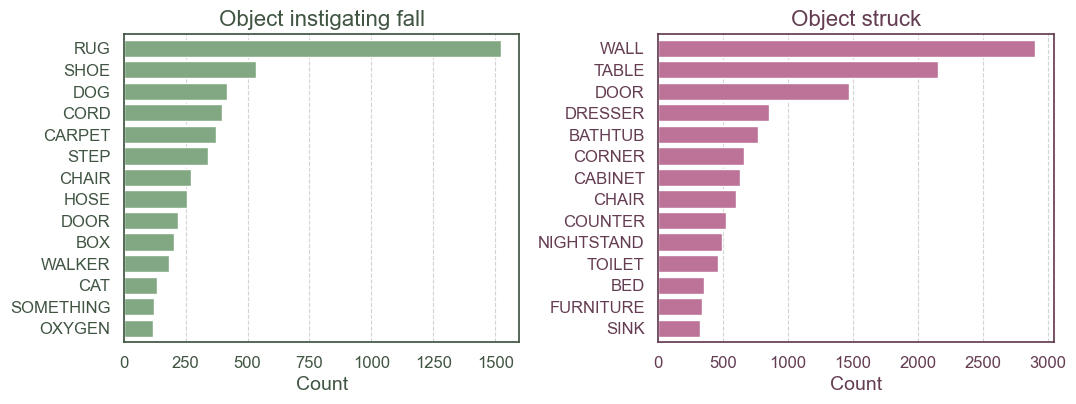

In [62]:
c1 = "#81a882" 
c2 = "#415543" 
c3 = "#bd7298"
c4 = "#653d53"

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
# fig.suptitle('Falls involving objects', size=20, y=1.02)
OBJ_plot_subset.plot.barh(width = 0.8, ax = ax1, color = c1)
SO_plot_subset.plot.barh(width = 0.8, ax = ax2, color = c3)
ax1.legend().set_visible(False) 
ax2.legend().set_visible(False) 
ax1.set_ylabel('')
ax2.set_ylabel('')
ax1.tick_params(labelsize=12)
ax2.tick_params(labelsize=12)
ax1.set_title("Object instigating fall", fontsize = 16, color = c2)
ax2.set_title("Object struck", fontsize = 16, color = c4)
ax1.set_xlabel('Count', fontsize = 14, color = c2)
ax2.set_xlabel('Count', fontsize = 14, color = c4)
ax1.grid(True, which='both', axis='x', linestyle='--', linewidth=0.8, color='lightgray')
ax2.grid(True, which='both', axis='x', linestyle='--', linewidth=0.8, color='lightgray')
ax1.tick_params(axis='y', labelcolor=c2)
ax2.tick_params(axis='y', labelcolor=c4)
ax1.tick_params(axis='x', labelcolor=c2)
ax2.tick_params(axis='x', labelcolor=c4)
for spine in ['left', 'right', 'top', 'bottom']:
    ax1.spines[spine].set_edgecolor(c2)
    ax2.spines[spine].set_edgecolor(c4)

plt.subplots_adjust(wspace=0.35)  #
plt.savefig("Objects_associated_with_falls.pdf", format="pdf", pad_inches = 0.25, bbox_inches = 'tight')

### Clean labels for plotting

In [63]:
# Remove the starting numbers from the category codes
combo_df['diagnosis'] = combo_df['diagnosis'].str.replace(r'\d+ - ', '', regex=True)
combo_df['disposition'] = combo_df['disposition'].str.replace(r'\d+ - ', '', regex=True)

# Change the diagnosis codes to sentence case
combo_df['diagnosis']= combo_df['diagnosis'].str.title()
print(combo_df['disposition'].unique())

['TREATED AND ADMITTED/HOSPITALIZED' 'TREATED/EXAMINED AND RELEASED'
 'HELD FOR OBSERVATION' 'TREATED AND TRANSFERRED'
 'LEFT WITHOUT BEING SEEN']


In [64]:
# Shorten the disposition names, keeping general meaning
label_mapping = {'TREATED AND ADMITTED/HOSPITALIZED': 'Admitted', 
                 'TREATED/EXAMINED AND RELEASED': 'Released', 
                 'HELD FOR OBSERVATION': 'Held', 
                 'TREATED AND TRANSFERRED': 'Transferred',  
                 'LEFT WITHOUT BEING SEEN': 'Unseen', }
combo_df['disposition'] = combo_df['disposition'].map(label_mapping)
print(combo_df['disposition'].unique())

['Admitted' 'Released' 'Held' 'Transferred' 'Unseen']


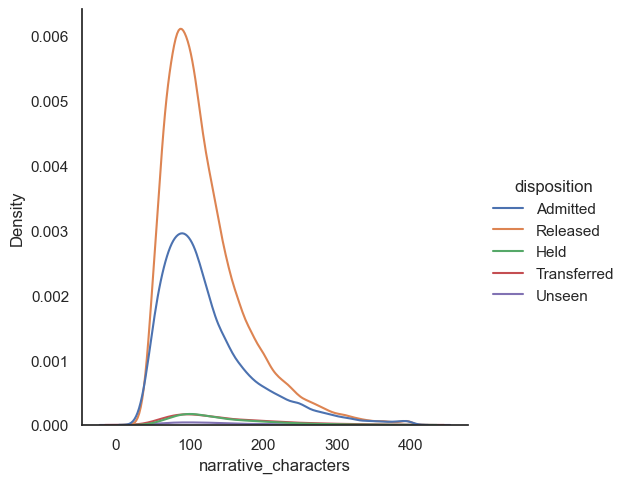

In [65]:
sns.displot(combo_df, x = 'narrative_characters', hue = 'disposition', kind = 'kde')

Gather rows for specific strike types

In [66]:
object_involved = combo_df[combo_df['OBJ'] == 1]
len(object_involved)
# Note this list ends up shorter than all unique OBJ entries because some cases might have OBJ in >1 span

9638

I will subset the data to include only cases where just one of these spans are labeled: struck object, struck floor, or struck unknown. In that way, I am improving the chance that I am separating cases with only a single type of striking. That is, I want to have a group of cases where it was recorded that an object was struck but there was no additional mention of striking the floor. Likewise, I want a group where striking the floor was mentioned but there was no additional mentioning of striking an object. Given the 90% precision and 80% recall of the model, and given that information may have been left out of the clinical narratives, these groupings will not be perfect. However, I will proceed with analyzing them, keeping in mind they carry with them some margin of error.

In [67]:
struck_object = combo_df[(combo_df['SO']==1) & (combo_df['SF']!=1) & (combo_df['SU']!=1)]
struck_floor = combo_df[(combo_df['SO']!=1) & (combo_df['SF']==1) & (combo_df['SU']!=1)]
struck_unknown = combo_df[(combo_df['SO']!=1) & (combo_df['SF']!=1) & (combo_df['SU']==1)]
print(len(struck_floor), len(struck_object), len(struck_unknown))

15553 17410 4696


Bind the struck object and struck floor sets back together for plotting

In [68]:
struck_object = struck_object.assign(struck = 'Object')
struck_floor = struck_floor.assign(struck = 'Floor')
striking_df = pd.concat([struck_object, struck_floor ], ignore_index=True) 
striking_df.head(3)

,cpsc_case_number,text,SO,SF,SU,OBJ,STR,WT,narrative,treatment_date,...,disposition,location,fire_involvement,alcohol,drug,product_1,product_2,product_3,narrative_characters,struck
0,190103309,74YOM FELL INTO A PLANTER BOX AND SUSTAINED A ...,1,0,0,0,0,0,74YOM FELL INTO A PLANTER BOX AND SUSTAINED A ...,2019-01-01,...,Released,HOME,NO/?,No/Unk,No/Unk,1413 - GREENHOUSE OR GARDENING SUPPLIES,0 - None,0 - None,57,Object
1,190104639,75 YOF C/O ANKLE FRACTURE S/P WAS WEARING A SI...,1,0,0,0,0,0,75 YOF C/O ANKLE FRACTURE S/P WAS WEARING A SI...,2019-01-01,...,Released,HOME,NO/?,No/Unk,No/Unk,1644 - NIGHTWEAR,"4076 - BEDS OR BEDFRAMES, OTHER OR NOT SPECIFIED","1893 - DOORS, OTHER OR NOT SPECIFIED",114,Object
2,190104659,69 YOM C/O FACIAL LACERATION S/P HAVING A NIG...,1,0,0,0,0,0,69 YOM C/O FACIAL LACERATION S/P HAVING A NIG...,2019-01-01,...,Released,HOME,NO/?,No/Unk,No/Unk,"4076 - BEDS OR BEDFRAMES, OTHER OR NOT SPECIFIED","4057 - TABLES (EXCL. BABY CHANGING TABLES, BI...",0 - None,111,Object


Plot disposition distribution for each category

In [69]:
strike_disp = striking_df[['disposition', 'struck' ]]
strike_disp_counts = strike_disp.groupby(['struck', 'disposition']).size().reset_index(name='count')
temp = strike_disp_counts.pivot(columns = 'disposition', index = 'struck', values = 'count' )
temp.columns.name=''
col_order = ['Released', 'Admitted', 'Held', 'Transferred', 'Unseen']
strike_disp_counts = temp[col_order]

<Figure size 800x400 with 0 Axes>

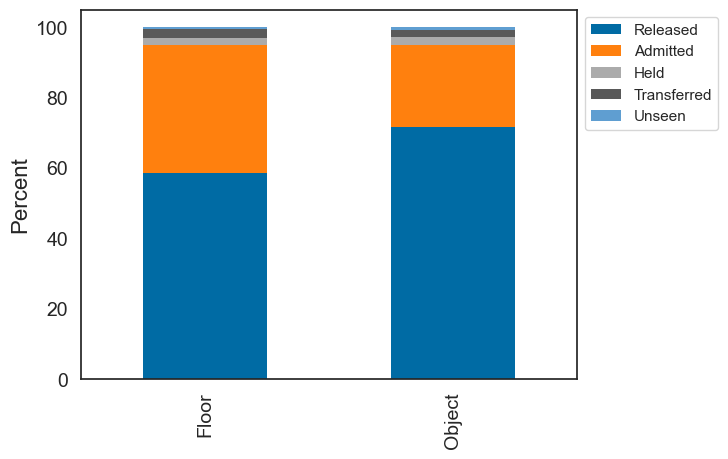

In [70]:
# Create the figure
plt.figure(figsize=(8, 4))

#sns.set_palette('colorblind')
plt.style.use('tableau-colorblind10')

# Convert to relative proportions 
strike_disp_counts.apply(lambda x: x*100/sum(x), axis = 1).plot(kind = 'bar', stacked = True, fontsize = 14, edgecolor='none')
plt.legend(bbox_to_anchor=(1, 1), loc=2) 
plt.ylabel("Percent", size = 16)
plt.xlabel("")
plt.savefig("Disposition_by_strike.pdf", format="pdf", pad_inches = 0.5, bbox_inches = 'tight')

In [71]:
diag_cols_to_use = ['Internal Injury',
 'Fracture',
 'Laceration',
 'Contusions, Abr.',
 'Avulsion',
 'Hematoma',
 'Concussion',
 'Strain, Sprain',
 'Dislocation']

In [72]:
striking_other = striking_df[striking_df['diagnosis'].isin(diag_cols_to_use) == False]

In [73]:
other_diag_counts = striking_other.groupby(['struck', 'diagnosis']).size().reset_index(name='count').groupby(['struck']).sum('count')
other_diag_counts.reset_index()
other_diag_counts.rename(columns = {'count': 'Other'}, inplace = True)
other_diag_counts

,Other
struck,
Floor,350
Object,404


In [74]:
strike_diag = striking_df[['diagnosis', 'struck' ]]
strike_diag_sub = strike_diag[strike_diag['diagnosis'].isin(diag_cols_to_use)]
strike_diag_counts = strike_diag_sub.groupby(['struck', 'diagnosis']).size().reset_index(name='count')
temp = strike_diag_counts.pivot(columns = 'diagnosis', index = 'struck', values = 'count' )
temp.columns.name=''
temp_ordered = temp[diag_cols_to_use]
strike_diag_counts = temp_ordered.merge(other_diag_counts, left_on = 'struck', right_on = 'struck')
strike_diag_counts

,Internal Injury,Fracture,Laceration,"Contusions, Abr.",Avulsion,Hematoma,Concussion,"Strain, Sprain",Dislocation,Other
struck,,,,,,,,,,
Floor,4574,5472,1191,2704,149,458,117,346,192,350
Object,6098,3203,3452,2683,325,673,206,270,96,404


In [75]:
import seaborn as sns

# Get the existing "Set1" palette which has 9 colors
existing_palette = sns.color_palette("Set1")

# Add one more color (for example, 'purple') to the existing palette
extended_palette = existing_palette + [(0.5, 0.0, 0.5)]

# Now, set this new palette as the default palette
sns.set_palette(extended_palette)

<Figure size 800x400 with 0 Axes>

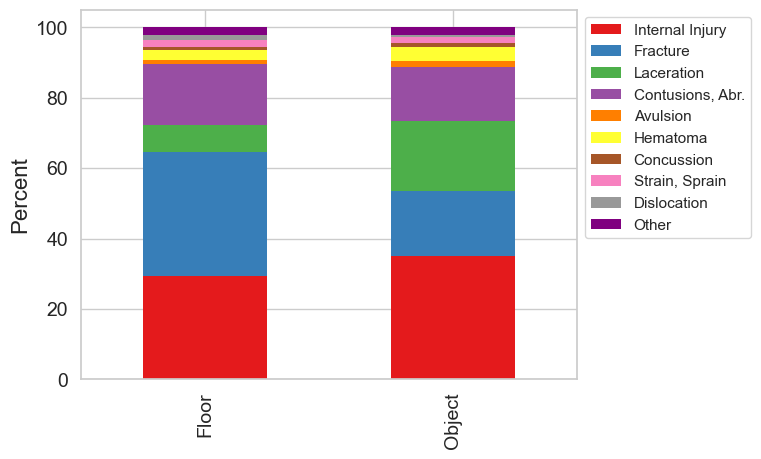

In [76]:
# Create the figure
plt.figure(figsize=(8, 4))
sns.set_style("whitegrid")
# sns.set_palette('extended_palette')
plt.style.use('fast')
strike_diag_counts.apply(lambda x: x*100/sum(x), axis = 1).plot(kind = 'bar', stacked = True, fontsize = 14, edgecolor = 'none')
plt.legend(bbox_to_anchor=(1, 1), loc=2) 
plt.ylabel("Percent", size = 16)
plt.xlabel("")
plt.savefig("Diagnosis_by_strike.pdf", format="pdf", pad_inches = 0.5, bbox_inches = 'tight')

In [77]:
# Get color palettes
palette1 = sns.color_palette(['navy','mediumpurple','turquoise','deeppink','dimgrey'])
# palette2 = sns.color_palette("Set1") + [(0.5, 0.0, 0.5)]
palette2 = ['maroon','goldenrod','darkcyan','#b3ad67','#f8ee93','salmon','mediumslateblue','lightblue','darkorange','dimgrey',]

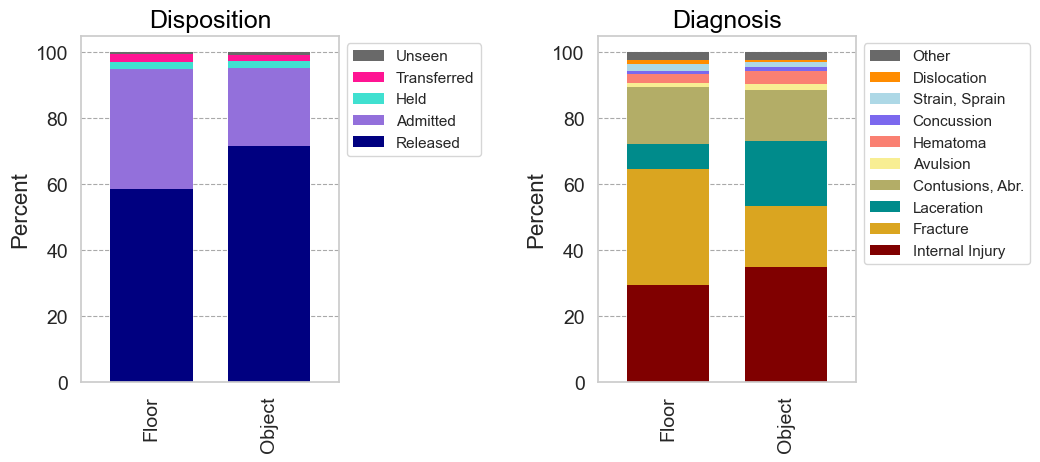

In [78]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4.5))
sns.set_style("white")
strike_disp_counts.apply(lambda x: x*100/sum(x), axis = 1).plot(kind = 'bar', width = 0.7, ax = ax1, stacked = True, fontsize = 14, edgecolor = 'none', color=palette1)
strike_diag_counts.apply(lambda x: x*100/sum(x), axis = 1).plot(kind = 'bar', width = 0.7, ax = ax2, stacked = True, fontsize = 14, edgecolor = 'none', color=palette2)
# Get and reverse legend for ax1
handles1, labels1 = ax1.get_legend_handles_labels()
ax1.legend(handles1[::-1], labels1[::-1]).set_bbox_to_anchor((1, 1))
# Get and reverse legend for ax2
handles2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(handles2[::-1], labels2[::-1]).set_bbox_to_anchor((1, 1))
ax1.set_xlabel("")
ax2.set_xlabel("")
ax1.set_ylabel("Percent", fontsize = 16)
ax2.set_ylabel("Percent", fontsize = 16)
ax1.set_title("Disposition", fontsize = 18, color = 'black')
ax2.set_title("Diagnosis", fontsize = 18, color = 'black')
ax1.grid(True, which='both', axis='y', linestyle='--', linewidth=0.8, color='darkgray')
ax2.grid(True, which='both', axis='y', linestyle='--', linewidth=0.8, color='darkgray')
plt.subplots_adjust(wspace=1)  #
plt.savefig("Struck_object_Disp_Diag.pdf", format="pdf", pad_inches = 0.2, bbox_inches = 'tight')

Look at frequencies of dispositon and diagnosis by strike type

In [79]:
sf_disp = struck_floor['disposition'].value_counts()
sf_disp

disposition
Released       9126
Admitted       5643
Transferred     375
Held            318
Unseen           91
Name: count, dtype: int64

In [80]:
so_disp = struck_object['disposition'].value_counts()
print(so_disp["Released"], so_disp["Admitted"])

12491 4066


Use an odds ratio contigency table to determine if the striking the floor has a higher risk of hospitalization than striking an object.

In [81]:
from scipy.stats.contingency import odds_ratio
res = odds_ratio([[sf_disp["Admitted"],so_disp["Admitted"]],[sf_disp["Released"],so_disp["Released"]]])
print(res.statistic, res.confidence_interval(confidence_level=0.95))

1.8995484485505283 ConfidenceInterval(low=1.8090840982718586, high=1.9946461824278392)


The odds of being admitted/hospitalized if a patient strikes the floor are 1.xx times (95% CI = 1.xx-1.xx) that of being admitted if a patient strikes an object.

In [83]:
so_diag = struck_object['diagnosis'].value_counts()

In [84]:
sf_diag = struck_floor['diagnosis'].value_counts()

In [85]:
sf_diag.sum() - sf_diag["Fracture"]

10081

In [86]:
res = odds_ratio([[sf_diag["Fracture"],so_diag["Fracture"]],[sf_diag.sum() - sf_diag["Fracture"], so_diag.sum() - so_diag["Fracture"]]])
print(res.statistic, res.confidence_interval(confidence_level=0.95))

2.407554253719156 ConfidenceInterval(low=2.288291887131683, high=2.5332880290133644)


In [87]:
res = odds_ratio([[sf_diag["Laceration"],so_diag["Laceration"]],[sf_diag.sum() - sf_diag["Laceration"], so_diag.sum() - so_diag["Laceration"]]])
print(res.statistic, res.confidence_interval(confidence_level=0.95))

0.3353226677205903 ConfidenceInterval(low=0.312422054795882, high=0.3597290814959434)


In [104]:
from spacy import displacy
colors = {'SO':'plum','SF':'lightskyblue','SU':'silver','OBJ':'palegreen','STR':'mistyrose','WT':'yellow'}
options = {"ents": ["sc"], "colors": colors}

In [105]:
x = binary_df[binary_df['cpsc_case_number']==190654735]
x2 = x.iloc[0,1]

In [106]:
doc = nlp_spancat(x2)
displacy.render(doc, style = 'span', options=options, jupyter = True)

In [107]:
x = binary_df[binary_df['cpsc_case_number']==190934697]
x2 = x.iloc[0,1]

In [108]:
doc = nlp_spancat(x2)
displacy.render(doc, style = 'span', options=options, jupyter = True)

## CONCLUSIONS

The model developed herein reveals potentially useful insights in regards to falling in older adults. While the model is not perfect, the effect sizes observed from the prediction spans are likely greater than the inaccuracy of the model.  

Two of the span categories that were labeled were not subjected to any additional analysis within this notebook: falling involving stairs and involving a patient waiting for help. Subsequent analysis of these two types of spans is likely to also reveal potentially useful information.

The utility of this approach is clearly demonstrated by the result seen.